# Data Exploration: Land surface temperature in Baltimore

In [1]:
%matplotlib inline
import os 
dir_primary = 'F:/UrbanDataProject/land_surface_temperature/code/analysis'
# os.chdir('/home/tml/research/land_surface_temperature/code/analysis')
os.chdir(dir_primary)
from analysis import *
code_dir = os.getcwd()
os.chdir('../..')

# import libraries
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

# regression libraries
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble.partial_dependence import plot_partial_dependence
from sklearn.ensemble.partial_dependence import partial_dependence
from sklearn.metrics import mean_squared_error, r2_score
# from xgboost import XGBRegressor

RANDOM_SEED = 3201

In [2]:
grid_size = 500
cities = ['bal', 'por', 'det', 'phx']
# import data
df = import_data(grid_size, selected_vars = False)
df_uns = pd.read_csv('data/data_regressions_{}_20190405_unnormalized.csv'.format(grid_size))

# Describe

In [3]:
df.head()

,alb_max,alb_max_sl,alb_mean,alb_mean_sl,alb_min,alb_min_sl,alb_sd,alb_sd_sl,bldg,city,...,tree_max,tree_max_sl,tree_mean,tree_mean_sl,tree_min,tree_min_sl,tree_sd,tree_sd_sl,x,y
0,-0.354169,0.291607,-0.579427,-0.607351,-0.653830,-0.586822,-0.175151,0.062593,0.797467,bal,...,-0.004023,-0.604159,-0.489894,-0.637884,-0.048624,-0.06784,-0.284225,-0.656385,424996.178971,189212.211496
1,-0.513546,-0.312432,-0.660572,-0.721739,-0.550292,-0.669227,-0.407968,-0.303042,0.228484,bal,...,-0.004023,-0.340398,-0.530055,-0.593108,-0.048624,-0.06784,-0.320845,-0.449581,425496.178971,189212.211496
2,-0.937259,-0.906217,-0.812375,-0.769144,-0.661609,-0.692135,-0.684661,-0.739024,0.231592,bal,...,0.039183,0.354648,-0.552869,-0.510769,-0.048624,-0.06784,-0.395489,-0.137117,425996.178971,189212.211496
3,-0.957408,-0.915058,-0.613889,-0.800411,-0.628720,-0.755022,-0.713723,-0.694649,0.574349,bal,...,-0.004023,0.547122,-0.504370,-0.404118,-0.048624,-0.06784,-0.471948,0.203295,426496.178971,189212.211496
4,0.161978,-1.035540,-0.437111,-0.801640,-0.670724,-0.761732,-0.144113,-0.769281,-0.014751,bal,...,-0.004023,0.547122,-0.284177,-0.455074,-0.048624,-0.06784,0.139201,0.054371,426996.178971,189212.211496


## Response

f:\urbandataproject\land_surface_temperature\venv\lib\site-packages\matplotlib\figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


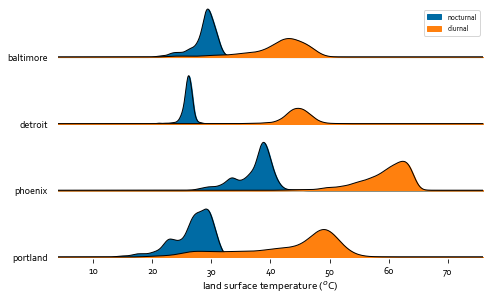

<Figure size 432x288 with 0 Axes>

In [4]:
joyplot_lst(df_uns, grid_size)

0.8899350087365586
0.8265334768784138
0.6394748475679407
0.8482425684618833


f:\urbandataproject\land_surface_temperature\venv\lib\site-packages\matplotlib\figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


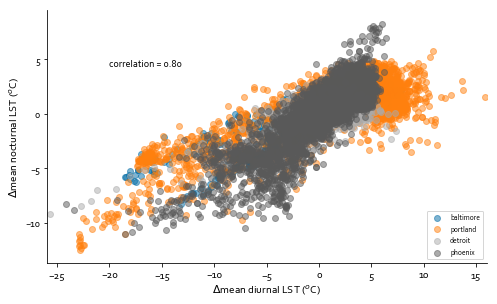

<Figure size 432x288 with 0 Axes>

In [5]:
# scatter and calculate the correlation between lst night and day
scatter_lst(df, cities, grid_size)

0.4106329171447106
0.3350110116908572
0.3304128258526793
0.7364904223642256


f:\urbandataproject\land_surface_temperature\venv\lib\site-packages\matplotlib\figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


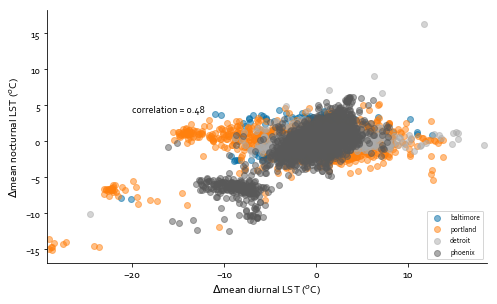

<Figure size 432x288 with 0 Axes>

In [6]:
scatter_maxlst(df, cities, grid_size)

# Independent variables

f:\urbandataproject\land_surface_temperature\venv\lib\site-packages\matplotlib\figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


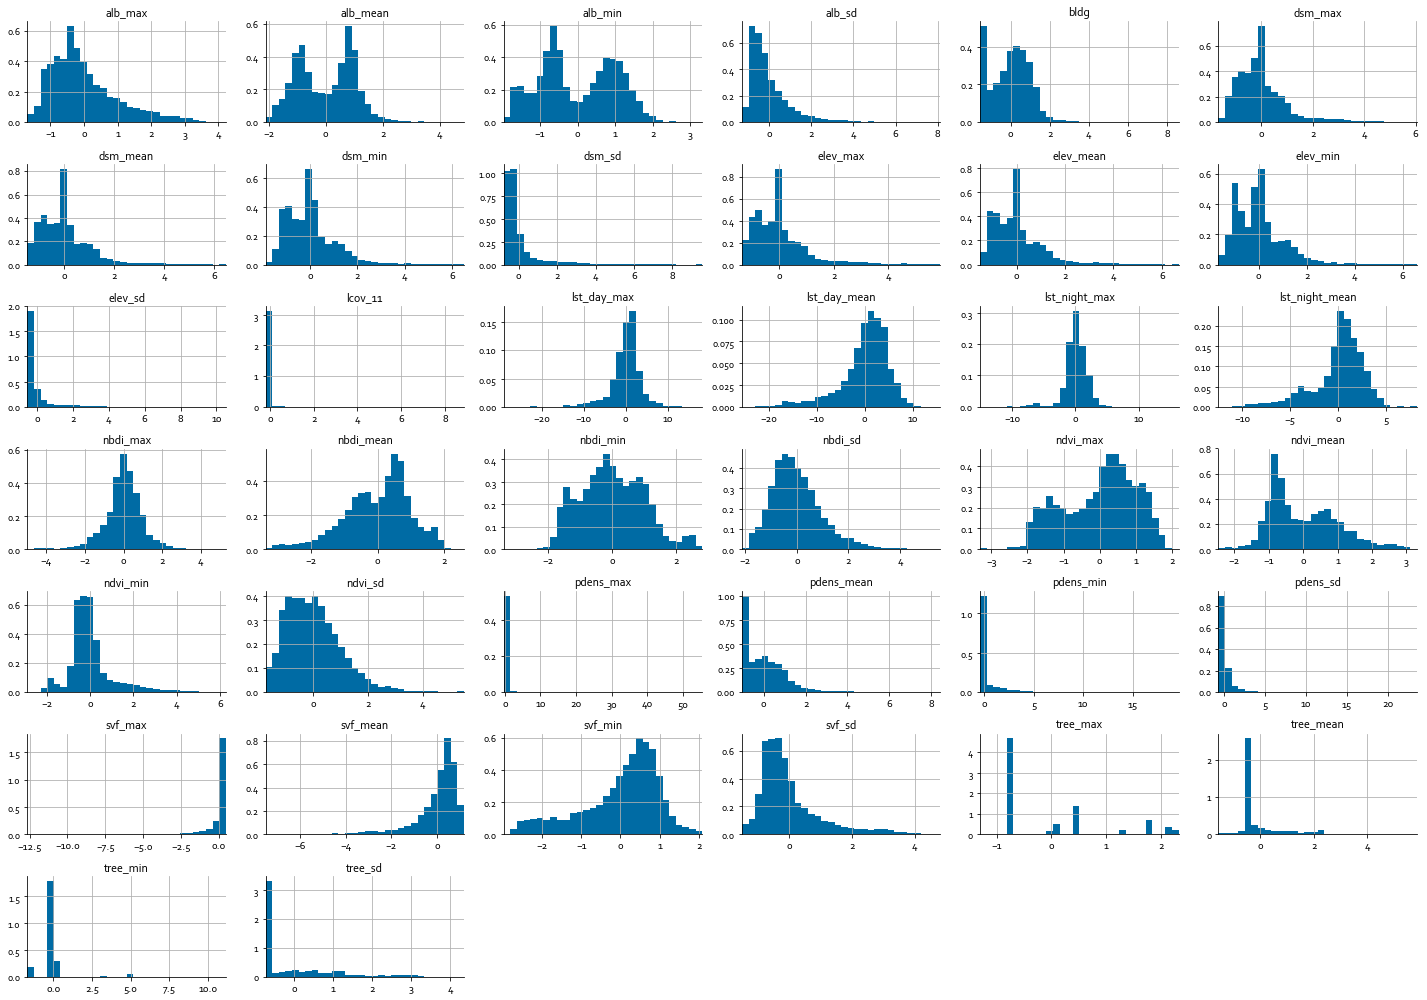

In [7]:
vars_plt = list(df.columns.values)
vars_plt = [x for x in vars_plt if x not in ['x','y','holdout']]
vars_plt = [x for x in vars_plt if 'sl' not in x]
df[vars_plt].hist(bins = 30, figsize=(20,14), density = True)
plt.show()

1.0
1.0
1.0
1.0


f:\urbandataproject\land_surface_temperature\venv\lib\site-packages\matplotlib\figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


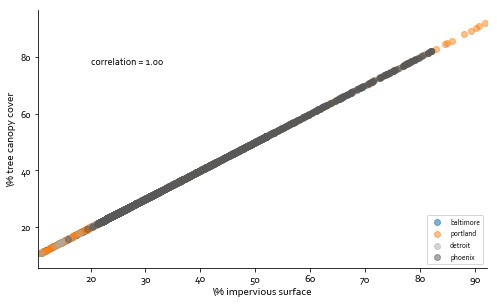

<Figure size 432x288 with 0 Axes>

In [8]:
# scatter impervious surface and tree canopy
scatter_tree_imp(df_uns, cities, grid_size)

## Drop variables based on collinearity

In [9]:
from patsy import dmatrices
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

## Automatic approach

In [10]:
# # run a regression

# #gather features
# vars_reg = [x for x in df.columns.values if x not in ['x','y','holdout',"lst_day_mean", 'lst_night_mean']]

# # loop until features with a vif > 10 are removed
# vif_10 = True
# while vif_10:
#     features = "+".join(vars_reg)
#     # get y and X dataframes based on this regression:
#     y, X = dmatrices('lst_night_mean ~' + features, df, return_type='dataframe')
#     # For each X, calculate VIF and save in dataframe
#     vif = pd.DataFrame()
#     vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
#     vif["features"] = X.columns
#     # is there a variable with vif > 10
#     vif_10 = vif['VIF Factor'].max() > 5
#     # remove the variable with the highest vif, if the vif is greater than 10
#     if vif_10:
#         var_remove = vif.loc[vif['VIF Factor'].idxmax(),'features']
#         vars_reg.remove(var_remove)  
#         print(var_remove)

## Manual approach
If the VIF values are similar, then I'll won't drop the mean

In [11]:
# run a regression
####### this if for grid_size 500 *** it may be different for grid_size=100
if grid_size == 500:
    vars_remove = ['elev_mean_sl', 'elev_mean', 'elev_min_sl','dsm_mean_sl', 'elev_max_sl','elev_min','elev_max','dsm_min',
                  'nbdi_mean_sl','svf_sd_sl','alb_mean_sl','dsm_sd_sl','nbdi_min_sl','dsm_max_sl','dsm_max','ndvi_mean_sl',
                   'ndvi_max_sl', 'ndvi_max', 'nbdi_mean','elev_sd','dsm_min_sl','alb_max_sl','alb_min_sl','svf_sd','svf_mean_sl',
                  'tree_sd_sl','ndvi_sd_sl', 'alb_min','ndvi_min_sl','nbdi_min']
    vars_remove_5 = ['elev_sd_sl','svf_min_sl','tree_sd','tree_mean_sl','ndvi_min','svf_max_sl','nbdi_max_sl','nbdi_sd',
                     'ndvi_sd','alb_max','alb_sd','alb_sd_sl','nbdi_sd_sl', 'svf_min']
    vars_remove_more = ['pdens_min','pdens_max','pdens_sd','']
    # drop if correlation is greater than 0.8
    vars_remove_corr = ['lcov_11_sl','tree_max_sl','tree_min_sl']
else: 
    # grid size = 100
    vars_remove = ['elev_mean_sl','elev_max_sl','elev_min_sl','elev_max','elev_min','dsm_mean_sl','dsm_min_sl','dsm_min',
                  'ndvi_max_sl','nbdi_min_sl','nbdi_mean_sl','ndvi_min_sl','nbdi_max_sl','ndvi_mean_sl','dsm_max_sl','alb_max_sl',
                  'alb_min_sl','alb_mean_sl','elev_mean','dsm_max','ndvi_max','tree_max_sl','svf_sd_sl','nbdi_min','nbdi_max',
                  'nbdi_mean','alb_max','tree_mean_sl','alb_min','ndvi_min','alb_sd','tree_min_sl','svf_mean_sl','tree_max',
                   'pdens_sd_sl','svf_sd','pdens_mean_sl','pdens_max_sl','svf_min_sl','pdens_sd','elev_sd_sl','dsm_sd_sl',
                   'tree_min','svf_min']
    vars_remove_5 = ['dsm_sd','lcov_11_sl','ndvi_sd_sl']
    vars_remove_more = ['alb_sd_sl',]
    # drop if correlation is greater than 0.8
    vars_remove_corr = ['pdens_min','pdens_max','pdens_sd','pdens_min_sl','elev_sd','svf_max_sl','nbdi_sd']
#gather features
vars_reg = [x for x in df.columns.values if x not in ['x','y','holdout','city',"lst_day_mean", 'lst_night_mean',"lst_day_max", 'lst_night_max'] + vars_remove + vars_remove_5 + vars_remove_more+ vars_remove_corr]

# evalue the VIF and inspect by eye. add variable to remove to vars_remove
features = "+".join(vars_reg)
# get y and X dataframes based on this regression:
y, X = dmatrices('lst_night_mean ~' + features, df, return_type='dataframe')
# For each X, calculate VIF and save in dataframe
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
# sort
vif = vif.sort_values(by='VIF Factor', ascending=False)
print(len(vif))
vif


14


,VIF Factor,features
7,4.833426,ndvi_mean
1,4.341470,alb_mean
10,3.679778,svf_mean
4,3.457057,dsm_sd
2,2.915220,bldg
12,2.633369,tree_mean
5,2.471424,lcov_11
9,2.139749,svf_max
6,2.103258,nbdi_max
11,1.947493,tree_max


In [12]:
# update df
variables = ['x','y','holdout','city',"lst_day_mean", 'lst_night_mean',"lst_day_max", 'lst_night_max'] + list(vif.features)
variables.remove('Intercept')
df = df[variables]

In [13]:
# save data
df.to_csv('data/data_vif_{}.csv'.format(grid_size))

# Explore correlations

In [14]:
corr_matrix = df.corr()
corr_matrix

,x,y,holdout,lst_day_mean,lst_night_mean,lst_day_max,lst_night_max,ndvi_mean,alb_mean,svf_mean,dsm_sd,bldg,tree_mean,lcov_11,svf_max,nbdi_max,tree_max,pdens_mean,dsm_mean,tree_min
x,1.000000,-0.888048,-0.123829,0.000691,0.000665,0.000265,0.000041,0.438908,-0.686658,-0.279741,-0.045187,-0.070037,-0.242172,0.037530,-0.082646,-0.249062,-0.266026,0.058323,0.000910,-0.089119
y,-0.888048,1.000000,0.527133,0.015458,0.007732,0.008774,-0.003019,-0.488175,0.655163,0.217699,0.067102,0.072703,0.275531,-0.047529,0.001154,0.233923,0.287291,-0.155834,0.026190,0.093123
holdout,-0.123829,0.527133,1.000000,0.047189,0.030031,0.027061,0.000240,-0.121121,-0.027517,-0.246129,0.147722,0.029886,0.092085,0.059600,-0.255290,-0.077155,0.135226,-0.179999,0.071658,-0.032870
lst_day_mean,0.000691,0.015458,0.047189,1.000000,0.796188,0.745026,0.319392,-0.243539,0.274795,0.172277,-0.415137,0.640176,-0.518811,-0.475889,0.245524,0.253699,-0.419623,0.428113,-0.292896,-0.081487
lst_night_mean,0.000665,0.007732,0.030031,0.796188,1.000000,0.484185,0.599830,-0.167716,0.199755,-0.041410,-0.254001,0.617252,-0.674959,-0.372941,0.099988,0.062078,-0.494783,0.408657,-0.175986,-0.155395
lst_day_max,0.000265,0.008774,0.027061,0.745026,0.484185,1.000000,0.481901,-0.343385,0.256423,0.280297,-0.398617,0.416250,-0.329056,-0.185387,0.293196,0.439005,-0.164259,0.173972,-0.442747,-0.349977
lst_night_max,0.000041,-0.003019,0.000240,0.319392,0.599830,0.481901,1.000000,-0.219684,0.145606,-0.007550,-0.173658,0.241164,-0.395440,0.009538,0.093307,0.127334,-0.165395,0.075701,-0.259386,-0.570809
ndvi_mean,0.438908,-0.488175,-0.121121,-0.243539,-0.167716,-0.343385,-0.219684,1.000000,-0.697892,-0.573522,0.183700,-0.213225,0.053949,-0.272908,-0.317536,-0.635201,0.028904,0.086438,0.264135,0.023946
alb_mean,-0.686658,0.655163,-0.027517,0.274795,0.199755,0.256423,0.145606,-0.697892,1.000000,0.572273,-0.234338,0.303067,0.112529,-0.245744,0.342888,0.559530,0.079470,-0.063771,-0.146996,0.095692
svf_mean,-0.279741,0.217699,-0.246129,0.172277,-0.041410,0.280297,-0.007550,-0.573522,0.572273,1.000000,-0.565945,-0.009964,0.030254,0.096973,0.619676,0.520110,0.051248,-0.119290,-0.371031,-0.049472


f:\urbandataproject\land_surface_temperature\venv\lib\site-packages\matplotlib\figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


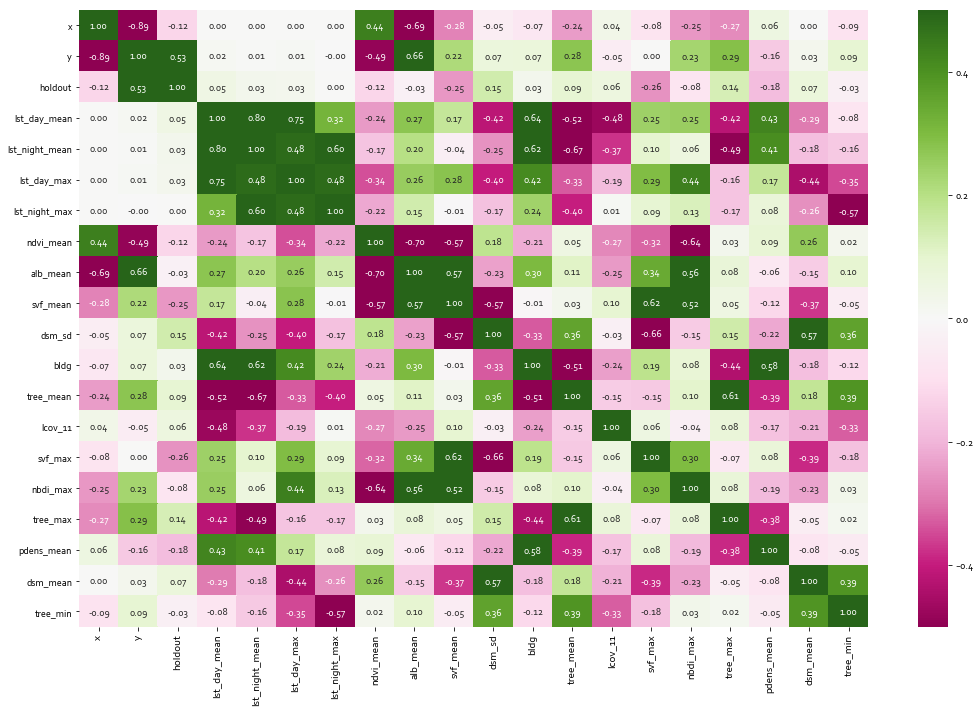

In [15]:
plt.figure(figsize=(15,10))
sns.heatmap(corr_matrix, 
            cmap='PiYG',
            xticklabels=corr_matrix.columns,
            yticklabels=corr_matrix.columns,
            vmin=-0.5,vmax=0.5,center=0, 
            annot = True, fmt='.2f')